In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

%config InlineBackend.figure_formats = ['svg']

----

$\hbar = 1$

---
# Hamiltonian

## Cooper Pair Box (CPB) Hamiltonian
$$H = 4 E_c (n - n_g)^2 - \frac{E_J}{2} \sum_n \big(| n + 1 \rangle \langle n | + c.c. \big)$$


$$H = 4 E_c (n - n_g)^2 - E_J \cos(\phi)$$


----
#### Charge Regime: $E_J/E_c \ll 1$


In [2]:
# truncated-Hilbert space dimension
N = 10 

# Initial offset
n_g = 1/2 


EJ = 1e9 # 1 GHz
Ec = 10e9 # 10 GHz
ratio = EJ/Ec # EJ/EC

n_vals = np.arange(-N//2, N//2)
n = Qobj(np.diag(n_vals))

# CPB Hamiltonian
H = 4 * Ec * (n-n_g)**2 - EJ/2 * Qobj(np.eye(N, k = 1) + np.eye(N, k = -1)) 

print(f"For Charge Regime, {ratio} which is less than 1")

For Charge Regime, 0.1 which is less than 1


In [3]:
ng_list = np.linspace(-2, 2, 1000) # sweeping across different ng values

def H(ng):
    return 4 * Ec * (n-ng)**2 - EJ/2 * Qobj(np.eye(N, k=1) + np.eye(N, k=-1))

energies = []
for ng in ng_list:
    evals = H(ng).eigenenergies()
    energies.append(evals[:3])
energies = np.array(energies)

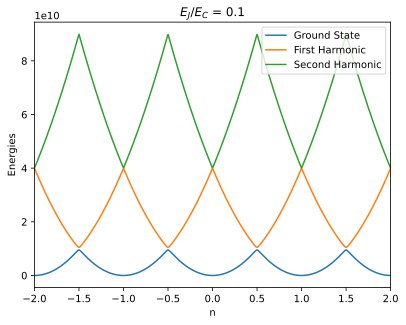

In [4]:
fig, ax = plt.subplots()
ax.plot(ng_list, energies[:, 0])
ax.plot(ng_list, energies[:, 1])
ax.plot(ng_list, energies[:, 2])
ax.set_title(r'${E_J}/{E_C}$ = 0.1')
ax.set_xlabel('n')
ax.set_ylabel('Energies')
ax.legend(('Ground State', 'First Harmonic', 'Second Harmonic'))
ax.set_xlim(-2, 2)
plt.show()

----
#### Transmon Regime: $E_J/E_c \gg 1$


In [5]:
#truncated-Hilbert space dimension
N = 25

n_vals = np.arange(-N//2, N//2)
n = Qobj(np.diag(n_vals))

cos_phi = 1/2 * (Qobj(np.eye(N, k=1) + np.eye(N, k=-1)))

Ec = 1e9
EJ = 50e9
ng = 1/2

H = 4 * Ec *(n-ng)**2 - EJ * cos_phi

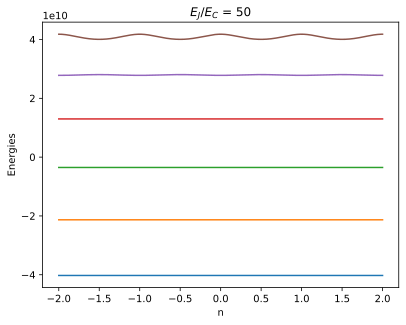

In [8]:
ng_list = np.linspace(-2, 2, 1000)

def H(ng):
    return 4 * Ec * (n-ng)**2 - EJ/2 * Qobj(np.eye(N, k=1) + np.eye(N, k=-1))

energies = []
for ng in ng_list:
    evals = H(ng).eigenenergies()
    energies.append(evals[:6])
energies = np.array(energies)

fig, ax = plt.subplots()
ax.plot(ng_list, energies[:, 0])
ax.plot(ng_list, energies[:, 1])
ax.plot(ng_list, energies[:, 2])
ax.plot(ng_list, energies[:, 3])
ax.plot(ng_list, energies[:, 4])
ax.plot(ng_list, energies[:, 5])
ax.set_title(r'${E_J}/{E_C}$ = 50')
ax.set_xlabel('n')
ax.set_ylabel('Energies')
plt.show()

In [9]:
# Qubit transition frequency
w01 = energies[0, 1] - energies[0, 0]


w12 = energies[0, 2] - energies[0, 1]

print(f"Qubit Transition Frequency: {w01:e}\nAnharmonicity: {w12 - w01:e}")

Qubit Transition Frequency: 1.894192e+10
Anharmonicity: -1.149223e+09


---
### Convergence Testing

In [11]:
# convergence testing
def H(n, ng, N):
    return 4 * Ec * (n-ng)**2 - EJ* Qobj(np.eye(N, k=1) + np.eye(N, k=-1))

N_list = np.arange(6, 30, 1)
ng_list = np.linspace(-2, 2, 1000)

var_E_all = []

for N in N_list:
    n = Qobj(np.diag(np.arange(-N//2, N//2)))
    energy_N = []

    for ng in ng_list:
        energy_N.append(H(n, ng, N).eigenenergies())
    energy = np.array(energy_N).reshape(len(ng_list), N)
    var_E_N = []
    for i in range(6):
        var_E_N.append(np.var(energy[:, i]))
    var_E_all.append(var_E_N)

varE = np.array(var_E_all)

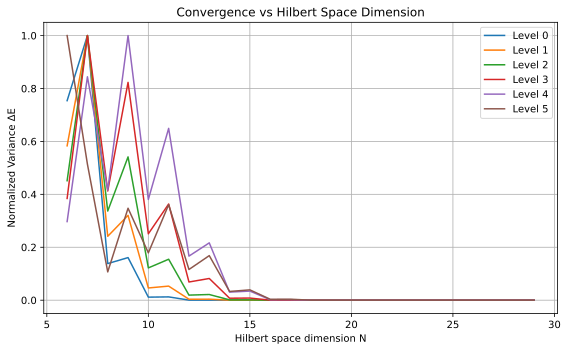

In [12]:
N_vals = np.arange(6, 30, 1) 
num_levels = varE.shape[1]

plt.figure(figsize=(8,5))

for i in range(num_levels):
    plt.plot(N_vals, varE[:, i] / varE[:, i].max(), label=f"Level {i}")

plt.xlabel("Hilbert space dimension N")
plt.ylabel("Normalized Variance ΔE")
plt.title("Convergence vs Hilbert Space Dimension")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Increasing N improves the approximation to the infinite-dimensional oscillator, causing the dependence of the energy spectrum on $n_g$ to vanish. This marks the transition toward the transmon regime, where the wavefunction spreads over many charge states and becomes insensitive to offset-charge noise, effectively suppressing charge dispersion.

----

## Driven Transmon

In [23]:
N = 25

n_vals = np.arange(-N//2, N//2)
n = Qobj(np.diag(n_vals))

cos_phi = 1/2 * (Qobj(np.eye(N, k=1) + np.eye(N, k=-1)))

Ec = 1 #GHz
EJ = 50 #GHz
ng = 1/2

H0 = 4 * Ec *(n-ng)**2 - EJ * cos_phi

In [38]:
evals, evecs = H0.eigenstates()

w01 = evals[1] - evals[0]

print("Qubit Transistion Frequency: ", w01)

Qubit Transistion Frequency:  18.94187929401842


In [33]:
# Transform every operator in the eigenbasis
U = Qobj(np.column_stack([vec.full() for vec in evecs]))
n_eig = U.dag() * n * U
H0_eig = U.dag() * H0 * U

In [46]:
def drive(t, args):
    return args["A"] * np.cos(args["wd"] * t)

H = [H0_eig, [n_eig, drive]]

# Initial State
psi0 = basis(N, 0) # Ground state in the eigenbasis (or U.dag() * evecs[0])


# Observables
proj_es1 = basis(N, 1) * basis(N, 1).dag()
proj_es2 = basis(N, 2) * basis(N, 2).dag()


tlist = np.linspace(0, 200, 1000)

# Time evolution
result = sesolve(H, psi0, tlist, e_ops=[proj_es1, proj_es2], args={"A":1e-1, "wd":w01}) # Resonant Drive

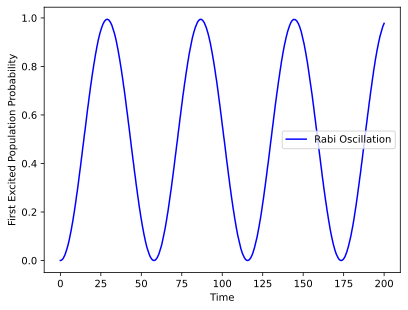

In [47]:
plt.plot(tlist, result.expect[0], 'b')
plt.legend(['Rabi Oscillation'])
plt.xlabel('Time')
plt.ylabel('First Excited Population Probability')
plt.show()

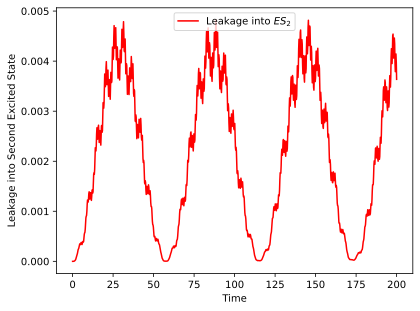

In [49]:
plt.plot(tlist, result.expect[1], 'r')
plt.legend([r'Leakage into $ES_2$'])
plt.xlabel('Time')
plt.ylabel('Leakage into Second Excited State')
plt.show()